In [1]:
from pyedflib import highlevel
import numpy as np 
import matplotlib.pyplot as plt
file_path = 'data/chb12_29.edf'

# Import data and visualize

In [2]:
# Read signals, signal headers, and file header in a single call
signals, signal_headers, header = highlevel.read_edf(file_path)


In [3]:
for i in signal_headers: print(i['label'], " ", end="")

F7  T7  P7  -  FP1  F3  C3  P3  01  -  FZ  CZ  PZ  -  FP2  F4  C4  P4  O2  -  F8  T8  P8  EKG1-CHIN  C2  C6  CP2  CP4  CP6  

Signals shape: (29, 927744)
Signal labels: 
F7  T7  P7  -  FP1  F3  C3  P3  01  -  FZ  CZ  PZ  -  FP2  F4  C4  P4  O2  -  F8  T8  P8  EKG1-CHIN  C2  C6  CP2  CP4  CP6  
Sample frequency of first channel: 256.0 Hz
Patient Name: 


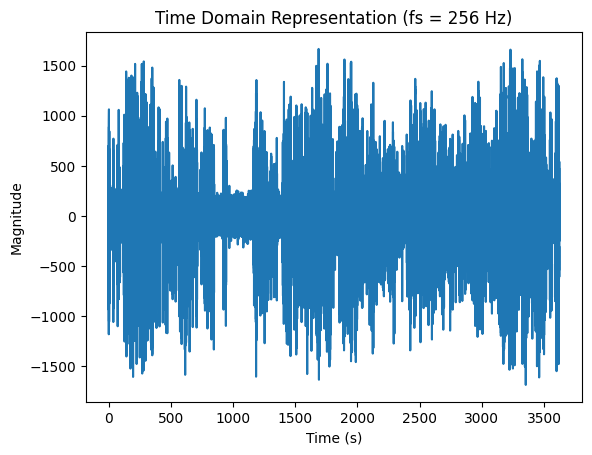

In [4]:
print(f"Signals shape: {signals.shape}")
print(f"Signal labels: ")
for i in signal_headers: print(i['label'], " ", end="") # Corrected to access labels from header dict
print()
print(f"Sample frequency of first channel: {signal_headers[0]['sample_frequency']} Hz")
print(f"Patient Name: {header['patientname']}")

# You can then plot the signals using a library like matplotlib (optional)
# import matplotlib.pyplot as plt
T=(1/signal_headers[0]['sample_frequency'])*np.arange(0,len(signals[0]),1)

plt.plot(T,signals[0])
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.title("Time Domain Representation (fs = 256 Hz)")
plt.savefig('figures/TDRinit.png',format='png')
plt.show()

In [5]:
np.max(signals[0])

np.float64(1666.6178266178267)

In [6]:
# --- Parameters ---
fs = 256.0            # Sampling frequency (Hz)
N = len(signals[0])       # Number of samples
t = np.arange(N) / fs

# --- Example signal (replace with your own) ---
# Sum of two sinusoids at 10 Hz and 40 Hz
signal = signals[4]

# --- FFT ---
X = np.fft.fft(signal)
freqs = np.fft.fftfreq(N, d=1/fs)

# Use only the positive frequencies
positive_freqs = freqs[:N // 2]
magnitude = np.abs(X[:N // 2]) / N

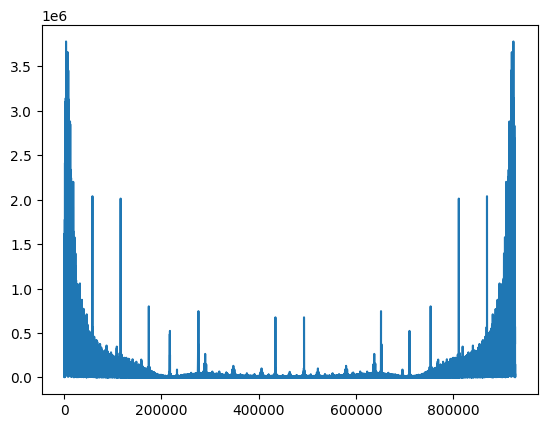

In [7]:
plt.plot(abs(X))

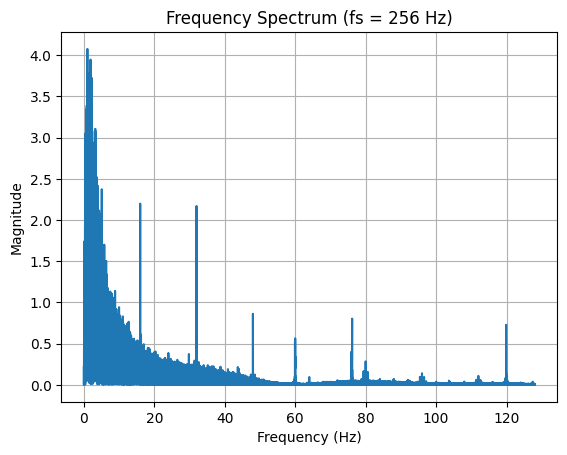

In [8]:
# --- Plot ---
plt.figure()
plt.plot(positive_freqs, magnitude)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum (fs = 256 Hz)")
plt.grid(True)
plt.savefig('figures/FDRinit.png')
plt.show()

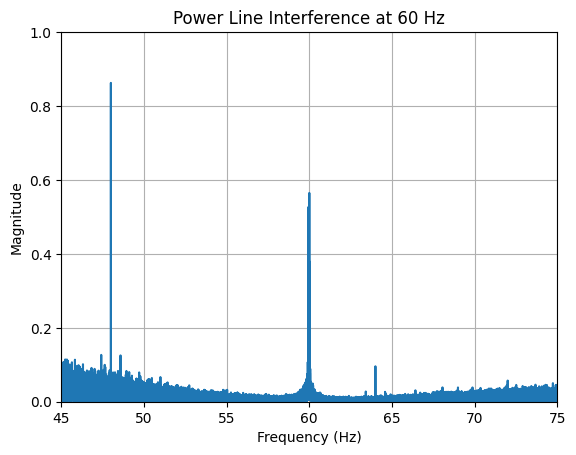

In [9]:
# --- Plot ---
plt.figure()
plt.plot(positive_freqs, magnitude)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Power Line Interference at 60 Hz")
plt.grid(True)
plt.xlim(45,75)
plt.ylim(0,1)
plt.savefig('figures/PLIinit.png')
plt.show()

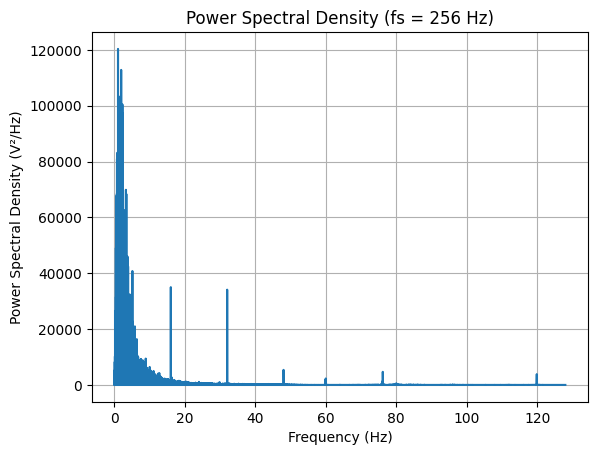

In [10]:
# --- FFT ---
X = np.fft.fft(signal)
freqs = np.fft.fftfreq(N, d=1/fs)

# --- PSD (two-sided) ---
PSD = (1 / (fs * N)) * np.abs(X)**2

# --- Convert to one-sided PSD ---
positive_freqs = freqs[:N // 2]
PSD_one_sided = PSD[:N // 2]
PSD_one_sided[1:-1] *= 2   # conserve total power

# --- Plot ---
plt.figure()
plt.plot(positive_freqs, PSD_one_sided)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (V²/Hz)")
plt.title("Power Spectral Density (fs = 256 Hz)")
plt.grid(True)
# plt.show()
# plt.xlim(0, 15)

plt.show()

# Filter Designs

In [11]:
import sys
sys.path.insert(0, "../src")  # add Folder_2 path to search list

import DFNotch
import IIR
import LS
from scipy import signal

Let's define the desired notch response

In [12]:
fc=60
fs=256
B=20
samples=10000

In [13]:
H=np.concatenate([np.ones(int((samples)*(2*(fc-B/2)/fs))),
                  np.linspace(1,0,int(samples*B/fs)),np.linspace(0,1,int(samples*B/fs)),
                  np.ones(int((samples)*(1-2*(fc+B/2)/fs)))])
H_z=np.concatenate([np.ones(int((samples)*(2*(fc-B/2)/fs))),
                  np.zeros(int(samples*2*B/fs)),
                  np.ones(int((samples)*(1-2*(fc+B/2)/fs)))])

In [14]:
len(H)

9999

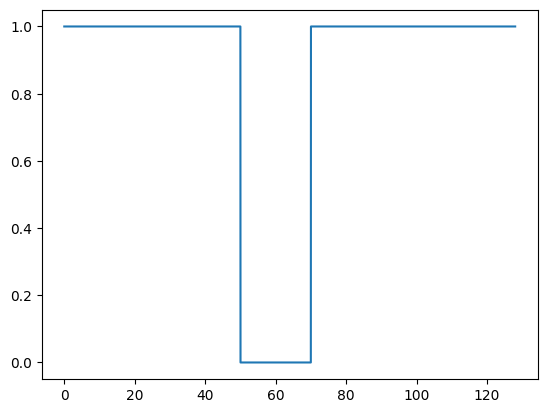

In [15]:
plt.plot(np.linspace(0,fs/2,len(H_z)),H_z)

## LS

In [16]:
h_LS=LS._LS(8,H_z)
h_LS

array([[-0.12221307],
       [ 0.04143977],
       [ 0.1471223 ],
       [-0.01517366],
       [ 0.84377912],
       [-0.01517366],
       [ 0.1471223 ],
       [ 0.04143977],
       [-0.12221307]])

In [17]:
t,d=signal.freqz(h_LS,whole=1)

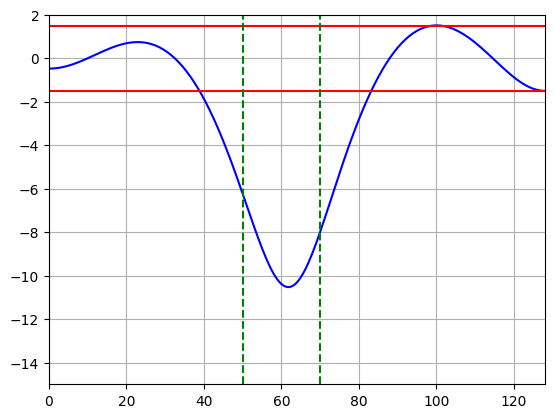

In [18]:
plt.plot(t/np.pi*fs/2, 20 * np.log10(abs(d)), 'b')
plt.xlim(0,fs/2)
plt.grid(True)

plt.ylim(-15,2)

# Add a horizontal reference line at y=0.5
plt.axhline(y=-1.5, color='r', linestyle='-', label='Threshold')
plt.axhline(y=1.5, color='r', linestyle='-', label='Threshold')

# Add a vertical line at x=5
plt.axvline(x=fc-B/2, color='g', linestyle='--', label='Event Start')
plt.axvline(x=fc+B/2, color='g', linestyle='--', label='Event Start')

plt.savefig("figures/pythonLSir.png")

It seems that it would be difficult to obtain a LS response which fits our specs. What might help us is a weight function

## WLS

In [19]:
bias=1e-1

In [20]:
w_z=np.concatenate([np.ones(int((samples)*(2*(fc-B/2)/fs)))-bias,
                  np.zeros(int(samples*B/fs)),
                  np.ones(int(1))*int(samples*2*B/fs)+bias*(samples)*((fs-B)/fs),
                  np.zeros(int(samples*B/fs)),
                  np.ones(int((samples)*(1-2*(fc+B/2)/fs)))-bias])/samples
w_z=w_z[0:len(H_z)]

In [21]:
sum(w_z)

np.float64(1.0076275000001371)

In [22]:
np.shape(w_z)

(9999,)

In [23]:
h_WLS=LS._WLS(8,H_z,w_z)
h_WLS

array([[-0.14492698],
       [ 0.04511329],
       [ 0.16505092],
       [-0.01598827],
       [ 0.82770823],
       [-0.01598827],
       [ 0.16505092],
       [ 0.04511329],
       [-0.14492698]])

In [24]:
t,d=signal.freqz(h_WLS,whole=1)

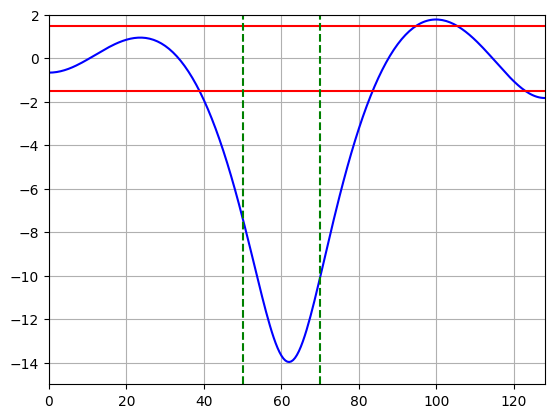

In [25]:
plt.plot(t/np.pi*fs/2, 20 * np.log10(abs(d)), 'b')
plt.xlim(0,fs/2)
plt.grid(True)

plt.ylim(-15,2)

# Add a horizontal reference line at y=0.5
plt.axhline(y=-1.5, color='r', linestyle='-', label='Threshold')
plt.axhline(y=1.5, color='r', linestyle='-', label='Threshold')

# Add a vertical line at x=5
plt.axvline(x=fc-B/2, color='g', linestyle='--', label='Event Start')
plt.axvline(x=fc+B/2, color='g', linestyle='--', label='Event Start')

plt.savefig("figures/pythonWLSir.png")

## IIR Pole-Zero Placement

if we approach this problem from a trivial perspective, it's just going to be a zero placed at the point of interest, which is the fc. 

In [26]:
z= np.exp(2*fc/fs*np.pi*1j)
p= z*0.8
z= [z, np.conj(z)]
p= [p,np.conj(p)]
g=0.9

b_pz, a_df= IIR._pz2iir(p,z,g)
a_pz=[1, *a_df]

In [27]:
b_pz

array([ 0.9       , -0.17643085,  0.9       ])

In [28]:
a_pz

[1, np.float64(-0.15682742452729725), np.float64(0.6400000000000001)]

In [29]:
t,d=signal.freqz(b_pz, a_pz ,whole=1)

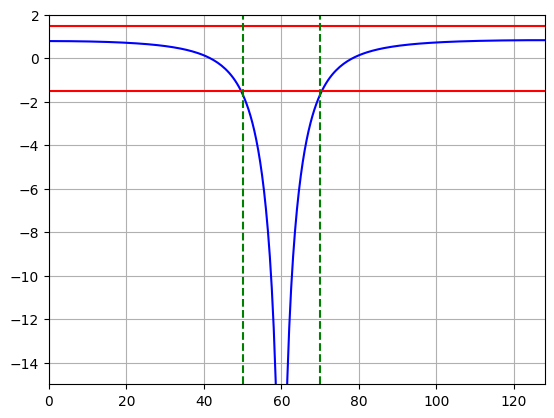

In [30]:
plt.plot(t/np.pi*fs/2, 20 * np.log10(abs(d)), 'b')
plt.xlim(0,fs/2)
plt.grid(True)

plt.ylim(-15,2)

# Add a horizontal reference line at y=0.5
plt.axhline(y=-1.5, color='r', linestyle='-', label='Threshold')
plt.axhline(y=1.5, color='r', linestyle='-', label='Threshold')

# Add a vertical line at x=5
plt.axvline(x=fc-B/2, color='g', linestyle='--', label='Event Start')
plt.axvline(x=fc+B/2, color='g', linestyle='--', label='Event Start')

plt.savefig("figures/pythonPZir.png")

## Direct Form Notching

In [31]:
b_df,a_df=DFNotch._NotchDF(fc,fs,B)

In [32]:
a_df=[1, *a_df]

In [33]:
t,d=signal.freqz(b_df, a_df ,whole=1)

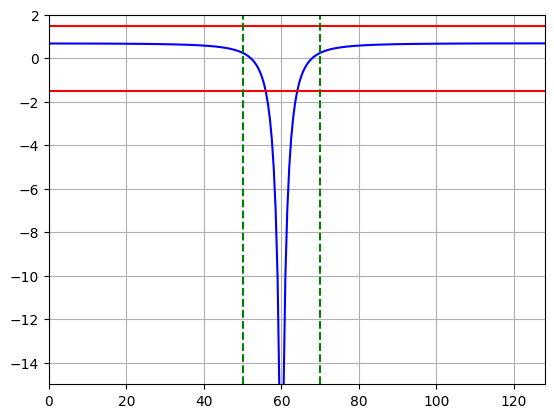

In [34]:
plt.plot(t/np.pi*fs/2, 20 * np.log10(abs(d)), 'b')
plt.xlim(0,fs/2)
plt.grid(True)

plt.ylim(-15,2)

# Add a horizontal reference line at y=0.5
plt.axhline(y=-1.5, color='r', linestyle='-', label='Threshold')
plt.axhline(y=1.5, color='r', linestyle='-', label='Threshold')

# Add a vertical line at x=5
plt.axvline(x=fc-B/2, color='g', linestyle='--', label='Event Start')
plt.axvline(x=fc+B/2, color='g', linestyle='--', label='Event Start')

plt.savefig("figures/pythonDFir.png")

## Exporting to mat files

In [35]:
import scipy.io as sio

In [40]:
python_df_Filter = {
    'a_df': a_df,
    'b_df': b_df
}
sio.savemat('filters/python_df_Filter.mat', python_df_Filter)

python_pz_Filter = {
    'a_pz': a_pz,
    'b_pz': b_pz
}
sio.savemat('filters/python_pz_Filter.mat', python_pz_Filter)

python_LS_Filter = {
    'h_LS': h_LS,
}
sio.savemat('filters/python_LS_Filter.mat', python_LS_Filter)

python_WLS_Filter = {
    'h_WLS': h_WLS,
}
sio.savemat('filters/python_WLS_Filter.mat', python_WLS_Filter)
